In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_log_error, make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
import re

pd.options.mode.copy_on_write = True

original_train_data = pd.read_csv('./data/train.csv')
transaction_data = pd.read_csv('./data/transactions.csv')
oil_data = pd.read_csv('./data/oil.csv')
store_data = pd.read_csv('./data/stores.csv')
holidays_data = pd.read_csv('./data/holidays_events.csv')


C:\Users\a239277\AppData\Local\Temp\ipykernel_2364\610009358.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
original_train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [3]:
transaction_data

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [4]:
oil_data

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [5]:
# Only National Holidays and transform transfered in Holiday

holidays_data = holidays_data[holidays_data['locale'] == 'National']
holidays_data = holidays_data[holidays_data['type'] != 'Event']
holidays_data = holidays_data[holidays_data['transferred'] == holidays_data['transferred'].iloc[0]]
holidays_data.rename({'type':'holiday'},inplace=True, axis=1)

holidays_data

,date,holiday,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [6]:
# Apply left join on train_data and transaction_data
original_train_data = pd.merge(original_train_data, transaction_data, on=['date','store_nbr'], how='left')

# Apply left join on train_data and oil_data
original_train_data = pd.merge(original_train_data, oil_data, on='date', how='left')

# Apply left join on train_data and store_data
original_train_data = pd.merge(original_train_data, store_data[['store_nbr','type','cluster']], on='store_nbr', how='left')

# Apply left join on train_data and holiday_data
original_train_data = pd.merge(original_train_data, holidays_data[['date','holiday']], on='date', how='left')

In [7]:
original_train_data

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,type,cluster,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,NaN,D,13,Holiday
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN,NaN,D,13,Holiday
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN,NaN,D,13,Holiday
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN,NaN,D,13,Holiday
4,4,2013-01-01,1,BOOKS,0.000,0,NaN,NaN,D,13,Holiday
...,...,...,...,...,...,...,...,...,...,...,...
3002665,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0,47.57,B,6,NaN
3002666,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,47.57,B,6,NaN
3002667,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0,47.57,B,6,NaN
3002668,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,47.57,B,6,NaN


In [8]:
# Convert date to datetime
original_train_data['date'] = pd.to_datetime(original_train_data['date'])

# Convert cluster to string
original_train_data['cluster'] = original_train_data['cluster'].astype(str)

# Convert holiday column to binary 1 or 0
original_train_data['holiday'] = original_train_data['holiday'].notnull()
original_train_data['holiday'] = original_train_data['holiday'] * 1

# Fill NaN values with 0
original_train_data['transactions'] = original_train_data['transactions'].fillna(0)

# Fill NaN values with interpolation
original_train_data['dcoilwtico'] = original_train_data['dcoilwtico'].interpolate()


# 2017 will be used as the test set
validation_data = original_train_data.loc[original_train_data['date'].dt.year == 2017]
train_data = original_train_data.loc[original_train_data['date'].dt.year < 2017]

train_data.is_copy = False


# Visualization of data

(array([15706., 15887., 16071., 16252., 16436., 16617., 16801., 16983.,
        17167.]),
 [Text(15706.0, 0, '2013-01'),
  Text(15887.0, 0, '2013-07'),
  Text(16071.0, 0, '2014-01'),
  Text(16252.0, 0, '2014-07'),
  Text(16436.0, 0, '2015-01'),
  Text(16617.0, 0, '2015-07'),
  Text(16801.0, 0, '2016-01'),
  Text(16983.0, 0, '2016-07'),
  Text(17167.0, 0, '2017-01')])

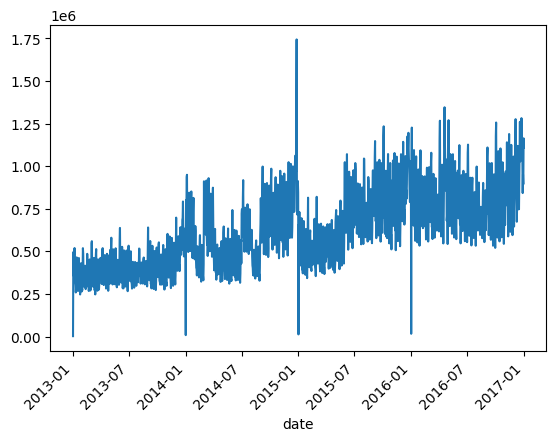

In [9]:
# See the sales data of each category by date
train_data.groupby('date')['sales'].sum().plot()
plt.xticks(rotation=45)

<Axes: xlabel='date'>

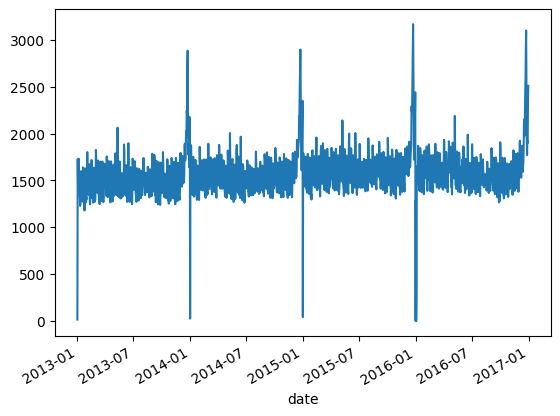

In [10]:
# See transactions data of each category by date
train_data.groupby('date')['transactions'].mean().plot()

In [11]:
train_data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

### Média Mensal - Vendas e transações

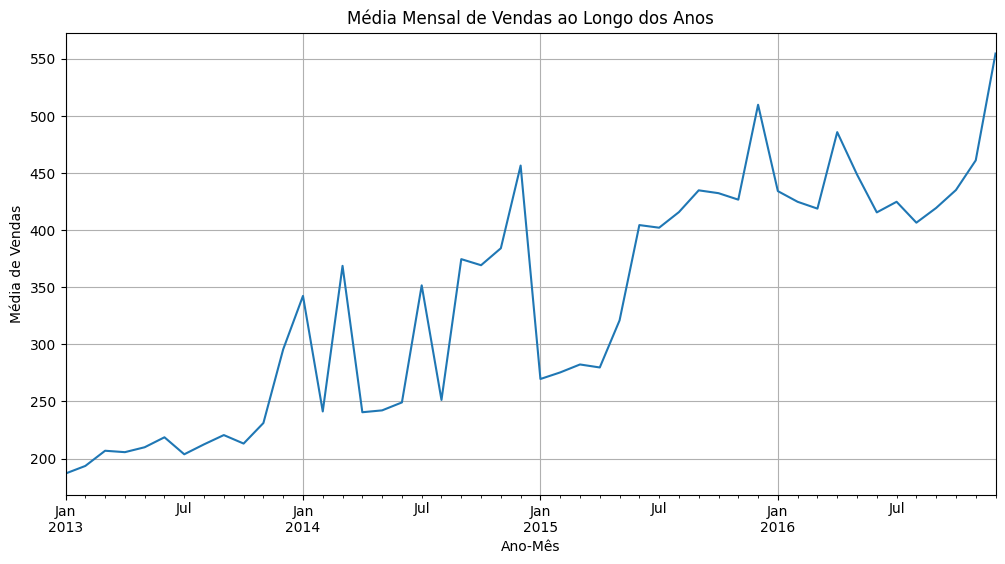

In [12]:
train_data['date'] = pd.to_datetime(train_data['date'])

train_data['year_month'] = train_data['date'].dt.to_period('M')

monthly_avg_sales = train_data.groupby('year_month')['sales'].mean()

monthly_avg_sales.plot(kind='line', figsize=(12, 6))
plt.xlabel('Ano-Mês')
plt.ylabel('Média de Vendas')
plt.title('Média Mensal de Vendas ao Longo dos Anos')

plt.grid(True)
plt.show()

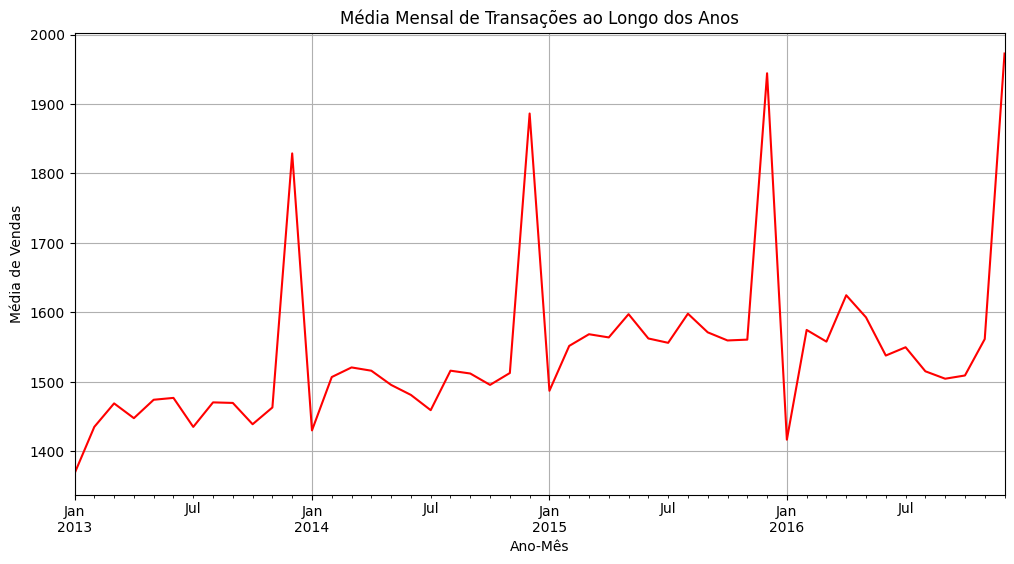

In [13]:
monthly_avg_sales = train_data.groupby('year_month')['transactions'].mean()

monthly_avg_sales.plot(kind='line', figsize=(12, 6), color='red')
plt.xlabel('Ano-Mês')
plt.ylabel('Média de Vendas')
plt.title('Média Mensal de Transações ao Longo dos Anos')


plt.grid(True)

plt.show()

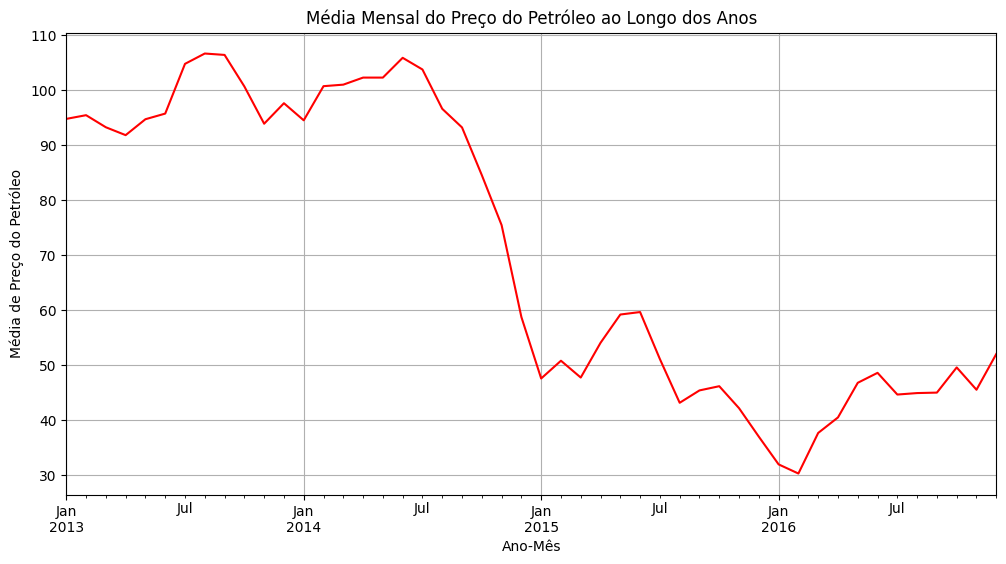

In [14]:
monthly_avg_oil_price = train_data.groupby('year_month')['dcoilwtico'].mean()

monthly_avg_oil_price.plot(kind='line', figsize=(12, 6), color='red')
plt.xlabel('Ano-Mês')
plt.ylabel('Média de Preço do Petróleo')
plt.title('Média Mensal do Preço do Petróleo ao Longo dos Anos')


plt.grid(True)

plt.show()

### Média por Dia da semana - Vendas e transações

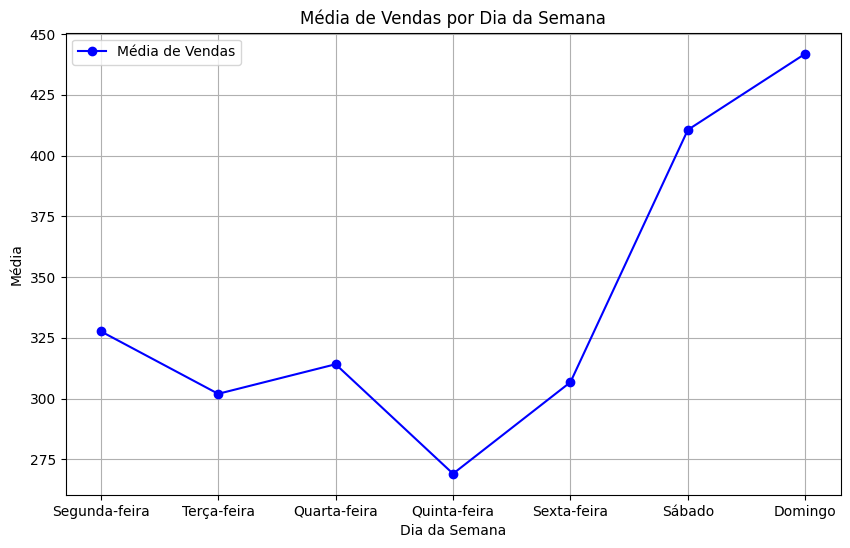

In [15]:
train_data['day_of_week'] = train_data['date'].dt.dayofweek

weekly_avg_sales = train_data.groupby('day_of_week')['sales'].mean()

days_of_week = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, weekly_avg_sales, marker='o', linestyle='-', color='b', label='Média de Vendas')
plt.xlabel('Dia da Semana')
plt.ylabel('Média')
plt.title('Média de Vendas por Dia da Semana')
plt.legend()
plt.grid(True)
plt.show()


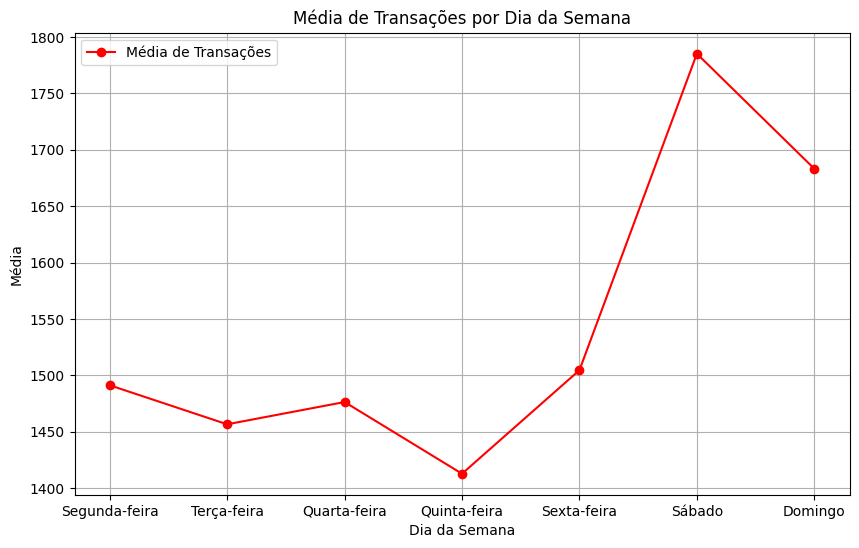

In [16]:
weekly_avg_transactions = train_data.groupby('day_of_week')['transactions'].mean()

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, weekly_avg_transactions, marker='o', linestyle='-', color='r', label='Média de Transações')
plt.xlabel('Dia da Semana')
plt.ylabel('Média')
plt.title('Média de Transações por Dia da Semana')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Convert date to ordinal
train_data.loc[:, 'ordinal_date'] = train_data['date'].apply(lambda x: x.toordinal() - 734868)

# Get only month 
train_data.loc[:, 'month'] = train_data['date'].dt.month

# Gey day of the year
train_data.loc[:, 'day_of_the_year'] = train_data['date'].dt.dayofyear

# Payment Day - Day 15 or end of the month
train_data.loc[:, 'payment_day'] = (train_data['date'].dt.day == 15) | (train_data['date'].dt.is_month_end == 1)


train_data.drop(['year_month'], axis=1, inplace=True)

### See correlation - Pearson and Spearman

<Axes: >

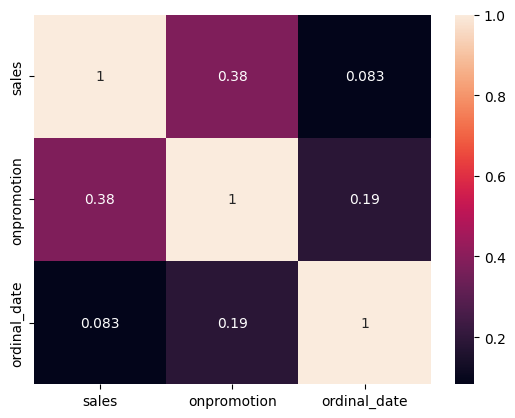

In [18]:
sns.heatmap(train_data[['sales', 'onpromotion','ordinal_date']].corr('pearson'), annot=True)

<Axes: >

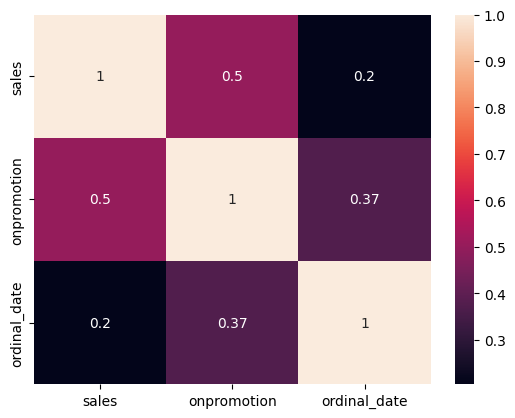

In [19]:
sns.heatmap(train_data[['sales', 'onpromotion','ordinal_date']].corr('spearman'), annot=True)

<Axes: >

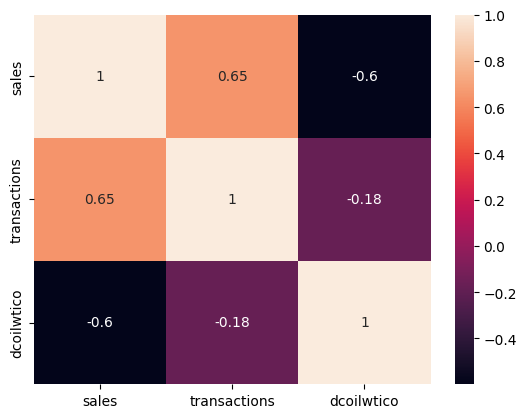

In [20]:
# See correlation between sum of sales and sum of transactions
sns.heatmap(train_data.groupby('date')[['sales', 'transactions', 'dcoilwtico' ]].sum().corr('pearson'), annot=True)

<Axes: >

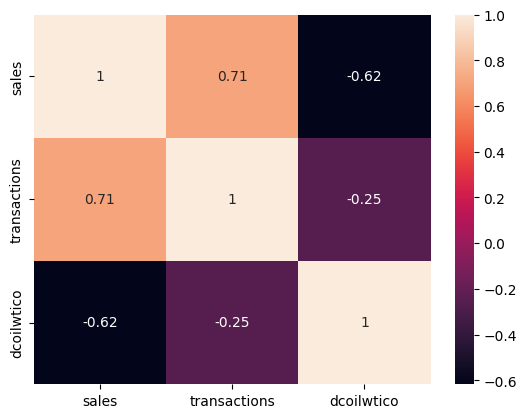

In [21]:
# See correlation between sum of sales and sum of transactions
sns.heatmap(train_data.groupby('date')[['sales', 'transactions','dcoilwtico']].sum().corr('spearman'), annot=True)

## See correlatin to previous sales

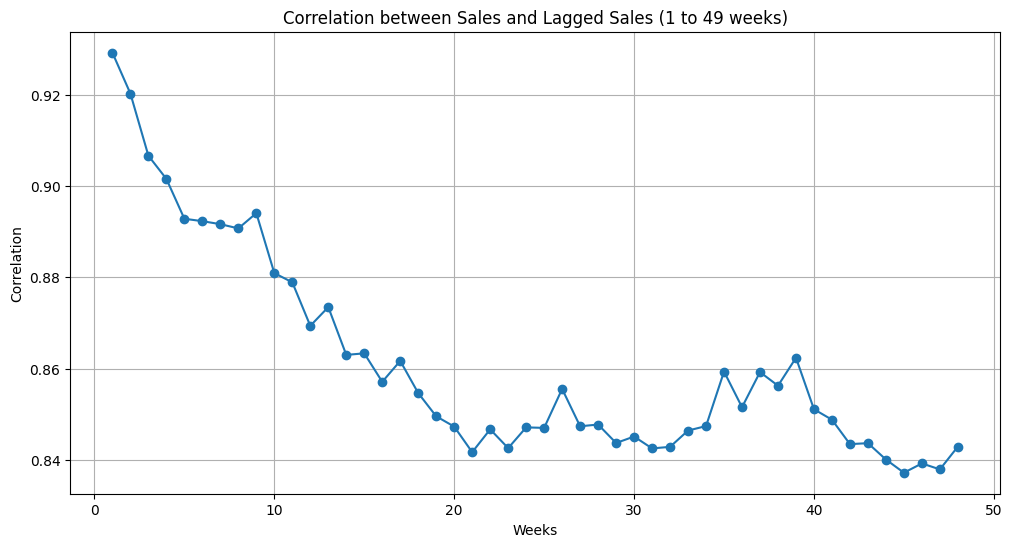

In [22]:
# Count the unique number of stores 
num_stores = train_data['store_nbr'].nunique()

# Supondo que train_data seja seu DataFrame
number_of_products = train_data['family'].nunique()

# Criar colunas de lag de 1 a 48 semanas
for week in range(1, 49):
    train_data[f'sales_lag_{week}_week'] = train_data['sales'].shift(week * 7 * number_of_products * num_stores)

# Calcular correlação entre 'sales' e cada coluna de lag
correlations = []
for week in range(1, 49):
    correlation = train_data['sales'].corr(train_data[f'sales_lag_{week}_week'])
    correlations.append(correlation)


# Fill NaN values with 0
train_data = train_data.fillna(0)

# Plotar as correlações
weeks = np.arange(1, 49)
plt.figure(figsize=(12, 6))
plt.plot(weeks, correlations, marker='o')
plt.xlabel('Weeks')
plt.ylabel('Correlation')
plt.title('Correlation between Sales and Lagged Sales (1 to 49 weeks)')
plt.grid(True)
plt.show()

C:\Users\a239277\AppData\Local\Temp\ipykernel_2364\1094856847.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f'transactions_lag_{week}_week'] = train_data['transactions'].shift(week * 7 * number_of_products * num_stores)
C:\Users\a239277\AppData\Local\Temp\ipykernel_2364\1094856847.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f'transactions_lag_{week}_week'] = train_data['transactions'].shift(week * 7 * number_of_products * num_stores)
C:\Users\a239277\AppData\Local\Temp\ipykernel_2364\109485684

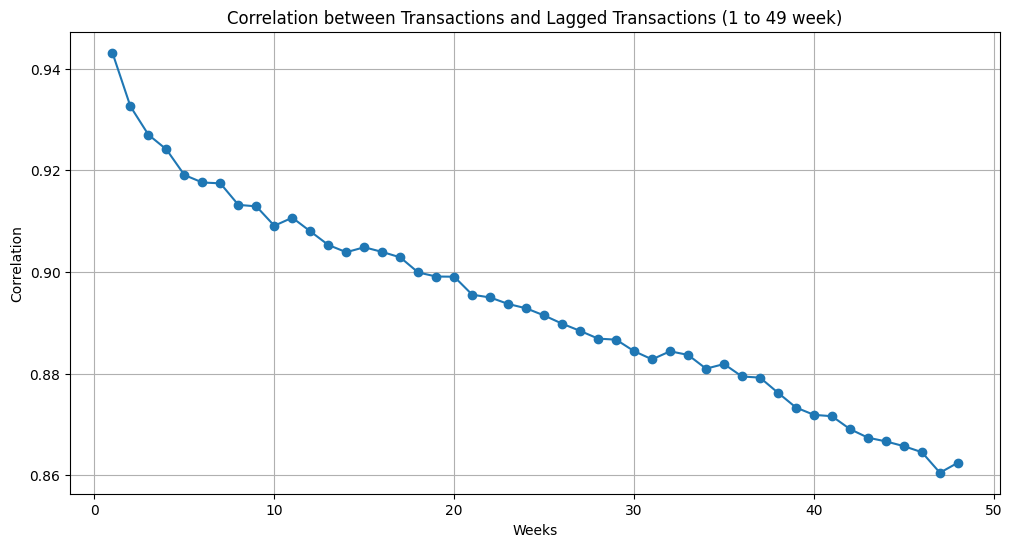

In [23]:
# Criar colunas de lag de 1 a 48 semanas
for week in range(1, 49):
    train_data[f'transactions_lag_{week}_week'] = train_data['transactions'].shift(week * 7 * number_of_products * num_stores)

# Calcular correlação entre 'sales' e cada coluna de lag
correlations = []
for week in range(1, 49):
    correlation = train_data['transactions'].corr(train_data[f'transactions_lag_{week}_week'])
    correlations.append(correlation)


# Fill NaN values with 0
train_data = train_data.fillna(0)

# Plotar as correlações
weeks = np.arange(1, 49)
plt.figure(figsize=(12, 6))
plt.plot(weeks, correlations, marker='o')
plt.xlabel('Weeks')
plt.ylabel('Correlation')
plt.title('Correlation between Transactions and Lagged Transactions (1 to 49 week)')
plt.grid(True)
plt.show()

# Transform Data


In [24]:
# Drop columns different from last 4 weeks - Weeks with highest correlation
for week in range(1, 49):
    if week not in [1, 2, 3, 4]:
        train_data.drop([f'sales_lag_{week}_week', f'transactions_lag_{week}_week'], axis=1, inplace=True)

In [25]:
train_data

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,type,cluster,...,day_of_the_year,payment_day,sales_lag_1_week,sales_lag_2_week,sales_lag_3_week,sales_lag_4_week,transactions_lag_1_week,transactions_lag_2_week,transactions_lag_3_week,transactions_lag_4_week
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0,0.000000,D,13,...,1,False,0.00000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0,0.000000,D,13,...,1,False,0.00000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0,0.000000,D,13,...,1,False,0.00000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0,0.000000,D,13,...,1,False,0.00000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,0.0,0.000000,D,13,...,1,False,0.00000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598151,2596369,2016-12-31,9,POULTRY,687.853,1,2998.0,53.287793,B,6,...,366,True,727.81903,414.634,451.309,441.374,3605.0,2144.0,2008.0,1880.0
2598152,2596370,2016-12-31,9,PREPARED FOODS,100.405,1,2998.0,53.287533,B,6,...,366,True,100.45400,124.490,100.765,93.000,3605.0,2144.0,2008.0,1880.0
2598153,2596371,2016-12-31,9,PRODUCE,3091.356,3,2998.0,53.287273,B,6,...,366,True,2575.08300,1233.849,1122.664,1128.173,3605.0,2144.0,2008.0,1880.0
2598154,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.000,0,2998.0,53.287013,B,6,...,366,True,0.00000,0.000,0.000,0.000,3605.0,2144.0,2008.0,1880.0


In [26]:
one_hot = OneHotEncoder(sparse_output=False)

# One hot on the columns
family_type_cluster_one_hot = one_hot.fit_transform(train_data[['family', 'type', 'cluster']])

# Concatenate the one hot encoded data with the original data
family_type_cluster_one_hot_df = pd.DataFrame(family_type_cluster_one_hot, columns=one_hot.get_feature_names_out(['family', 'type', 'cluster']))
train_data = pd.concat([train_data.reset_index(drop=True), family_type_cluster_one_hot_df.reset_index(drop=True)], axis=1)


In [27]:
# Drop columns that are not needed
train_data = train_data.drop(columns=['id','family','type','cluster','date','store_nbr'])

## Scaling the features

In [28]:
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


Y_train_data = train_data['sales']
X_train_data = train_data.drop(columns=['sales','transactions'])

X_scaled_train_data = min_max_scaler.fit(X_train_data)
X_scaled_train_data = min_max_scaler.transform(X_train_data)

X_scaled_train_data = pd.DataFrame(X_scaled_train_data, columns=X_train_data.columns)


## Testing models

In [29]:
validation_data['day_of_week'] = validation_data['date'].dt.dayofweek

validation_data['ordinal_date'] = validation_data['date'].apply(lambda x: x.toordinal() - 734868)

validation_data['month'] = validation_data['date'].dt.month

validation_data['day_of_the_year'] = validation_data['date'].dt.dayofyear

validation_data['payment_day'] = (validation_data['date'].dt.day == 15) | (validation_data['date'].dt.is_month_end == 1)


# Create columns of lag from last 4 weeks
for week in [1, 2, 3, 4]:
    validation_data[f'sales_lag_{week}_week'] = validation_data['sales'].shift(week * 7 * number_of_products * num_stores)

for week in [1, 2, 3, 4]:
    validation_data[f'transactions_lag_{week}_week'] = validation_data['transactions'].shift(week * 7 * number_of_products * num_stores)
    
# Fill NaN values with 0
validation_data = validation_data.fillna(0)

one_hot = OneHotEncoder(sparse_output=False)

family_type_cluster_one_hot = one_hot.fit_transform(validation_data[['family', 'type', 'cluster']])


# Concatenate the one hot encoded data with the original data
family_type_cluster_one_hot_df = pd.DataFrame(family_type_cluster_one_hot, columns=one_hot.get_feature_names_out(['family', 'type', 'cluster']))
validation_data = pd.concat([validation_data.reset_index(drop=True), family_type_cluster_one_hot_df.reset_index(drop=True)], axis=1)

validation_data = validation_data.drop(columns=['id','family','type','cluster','date','store_nbr'])

validation_data = validation_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y_validation_data = validation_data['sales']
x_validation_data = validation_data.drop(columns=['sales','transactions'])

# Scaler used in train data
X_scaled_validation_data = min_max_scaler.transform(x_validation_data)

X_scaled_validation_data = pd.DataFrame(X_scaled_validation_data, columns=x_validation_data.columns)



In [30]:
models_to_test = []
rmsle_error = []

model_dict = {
    'Linear Regression': LinearRegression(n_jobs = -1),
    'LightGBM Regressor': lgb.LGBMRegressor(n_jobs = -1),
}

# Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    y_pred = np.clip(y_pred, 0, None)  # Ensure no values are less than 0
    error = root_mean_squared_log_error(y_valid, y_pred)
    models_to_test.append(name)
    rmsle_error.append(error)


# Loop through the models and append the scores
i = 0
for name, model in model_dict.items():
    input_scores(name, model, X_scaled_train_data, Y_train_data, X_scaled_validation_data, y_validation_data)
    print(models_to_test[i], rmsle_error[i])
    i+=1

Linear Regression 1.3127769859243839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3132
[LightGBM] [Info] Number of data points in the train set: 2598156, number of used features: 71
[LightGBM] [Info] Start training from score 338.817216
LightGBM Regressor 0.7238363745046686


In [31]:
test_data = pd.read_csv('./data/test.csv')

test_data = pd.merge(test_data, oil_data, on='date', how='left')

test_data = pd.merge(test_data, store_data[['store_nbr','type','cluster']], on='store_nbr', how='left')

test_data = pd.merge(test_data, holidays_data[['date','holiday']], on='date', how='left')

test_data['date'] = pd.to_datetime(test_data['date'])

test_data['holiday'] = test_data['holiday'].notnull()
test_data['holiday'] = test_data['holiday'] * 1

test_data['cluster'] = test_data['cluster'].astype(str)


# Concat original and test data
lag_df = pd.concat([original_train_data, test_data], axis=0)

# Create columns of lag from last 4 weeks
for week in [1, 2, 3, 4]:
    lag_df[f'sales_lag_{week}_week'] = lag_df['sales'].shift(week * 7 * number_of_products * num_stores)

for week in [1, 2, 3, 4]:
    lag_df[f'transactions_lag_{week}_week'] = lag_df['transactions'].shift(week * 7 * number_of_products * num_stores)




In [32]:
test_data['day_of_week'] = test_data['date'].dt.dayofweek

test_data['ordinal_date'] = test_data['date'].apply(lambda x: x.toordinal() - 734868)

test_data['month'] = test_data['date'].dt.month

test_data['day_of_the_year'] = test_data['date'].dt.dayofyear

test_data['payment_day'] = (test_data['date'].dt.day == 15) | (test_data['date'].dt.is_month_end == 1)


# Number of unique products and stores
number_of_products = len(test_data['family'].unique())
num_stores = len(test_data['store_nbr'].unique())

# Join the lag_df with the test_data
test_data = pd.merge(test_data, lag_df[['id', 'sales_lag_1_week', 'sales_lag_2_week', 'sales_lag_3_week', 'sales_lag_4_week', 'transactions_lag_1_week', 'transactions_lag_2_week', 'transactions_lag_3_week', 'transactions_lag_4_week']], on=['id'], how='inner')

# Fill NaN values with 0
test_data = test_data.fillna(0)

one_hot = OneHotEncoder(sparse_output=False)

family_type_cluster_one_hot = one_hot.fit_transform(test_data[['family', 'type', 'cluster']])


# Concatenate the one hot encoded data with the original data
family_type_cluster_one_hot_df = pd.DataFrame(family_type_cluster_one_hot, columns=one_hot.get_feature_names_out(['family', 'type', 'cluster']))
test_data = pd.concat([test_data.reset_index(drop=True), family_type_cluster_one_hot_df.reset_index(drop=True)], axis=1)

test_data = test_data.drop(columns=['id','family','type','cluster','date','store_nbr'])

test_data = test_data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))



# Scaler used in train data
scaled_test_data = min_max_scaler.transform(test_data)

scaled_test_data = pd.DataFrame(scaled_test_data, columns=test_data.columns)

## Make submission

In [33]:
# Import sample submission
sample_submission = pd.read_csv('./data/sample_submission.csv')

# Train the model with the entire data
model = lgb.LGBMRegressor(n_jobs=-1)

all_data = pd.concat([X_scaled_train_data, X_scaled_validation_data], axis=0)
all_target = pd.concat([Y_train_data, y_validation_data], axis=0)

model.fit(all_data, all_target)

# Predict the test data
submission_pred = model.predict(scaled_test_data)
sample_submission['sales'] = np.clip(submission_pred, 0, None)  # Ensure no values are less than 0


sample_submission.to_csv('submission_7.csv', index=False)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.683029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3137
[LightGBM] [Info] Number of data points in the train set: 3002670, number of used features: 71
[LightGBM] [Info] Start training from score 357.853860
